# COVID19 Online News Classification using NLP



## Gdelt Data Analysis - How have reporting on topics surrounding covid changed in 2022 as compared to 2021?


 

# Introduction

As global cases of COVID19 began to rise from Dec 2019, we witnessed an increase in news reporting on COVID19 related topics (such as panic, shortage, testing, quarantine etc) globally on a daily basis. Every news agency be it TV or Online had something to report, mostly negative. If 2020 was dominated by the news of how COVID-19 spread across the globe, then 2021 has so far been focused on ending the pandemic through vaccine distribution. As vacciness began to roll out and the rate of deaths reducing significantly, the rate of reporting began to decrease and media focus was shifted to new topics. 

This project is to compare how reporting on topics surrounding covid has changed between 2021 and 2022. The initial plan was to compare the first quarter of 2021 and 2022 but given the size of the data, it had to be limited to the months of January only. After which i will train a news category classifier with the data using NLP on the data from January 2022.

# Import Libraries

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
import re

nltk.download("stopwords")
nltk.download("wordnet")
from nltk.corpus import stopwords

stopwords = stopwords.words("english")
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
import pickle
from wordcloud import WordCloud, STOPWORDS
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data

The data was extracted from the gdelt public data available on Google big query and because of the limitations and difficulty in getting it directly from Google Big Query, I extracted it through kaggle which can access Big Query directly. The final step was to upload it into google drive for use in Colab.

This data reflects news reported online. The notebook used has been uploaded in GitHub.

As I earlier stated in my introduction, the data had to be limited to just one month of each year due to the download size.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
cd drive

/content/drive


In [2]:
cd /content/drive/MyDrive/gdelt/data

/content/drive/MyDrive/gdelt/data


In [3]:
ls

 covid_onlinenews2021.csv  'covid_onlinenews2022 .csv'   gdelt.ipynb


### Data for January 2021 labelled as 'df1'.

In [4]:
df1 = pd.read_csv("/content/drive/MyDrive/gdelt/data/covid_onlinenews2021.csv")
df1.head()

,Unnamed: 0,Topic,DateTime,URL,Title,Context
0,0,Panic,2021-01-28 12:04:18+00:00,https://www.alaskahighwaynews.ca/covid-19-trav...,COVID-19 travel-related cases rise and U.S. te...,The bulletin is an indication that national se...
1,1,Panic,2021-01-28 09:47:59+00:00,https://www.570news.com/2021/01/28/covid-19-tr...,COVID-19 travel-related cases rise and U.S. te...,The bulletin is an indication that national se...
2,2,Panic,2021-01-28 22:48:19+00:00,https://www.wrcbtv.com/story/41867206/update-7...,"UPDATE: 717,583 COVID-19 cases, 9,417 deaths r...",The Hamilton County Health Department reports ...
3,3,Panic,2021-01-28 16:49:08+00:00,https://www.lagrandeobserver.com/coronavirus/u...,Umatilla County sponsors Spanish-speaking radi...,"With little help and care, their symptoms wors..."
4,4,Panic,2021-01-28 16:33:04+00:00,https://www.cbsnews.com/news/teen-helps-mother...,Texas teen's desperate plea reaches governor: ...,"In January, Erika Calderon was admitted to a h..."


In [5]:
df1=df1.drop(['Unnamed: 0'], axis = 1)

### Data for January 2022 labelled as 'df2'.

In [6]:
df2 = pd.read_csv("/content/drive/MyDrive/gdelt/data/covid_onlinenews2022.csv")
df2.head()

,Unnamed: 0,Topic,DateTime,URL,Title,Context
0,0,Panic,2022-01-03 22:17:30+00:00,https://bleedingcool.com/tv/wwe-champion-to-pr...,WWE Champion to Probably Appear on WWE Raw Ton...,The official logo for WWE Monday Night Raw. Cr...
1,1,Panic,2022-01-03 10:32:10+00:00,https://www.cobrapost.com/blog/yogi-adityanath...,:: Cobrapost ::,"News ""Omicron Spreads Fast But Is Weak, Like ..."
2,2,Panic,2022-01-03 04:16:42+00:00,https://www.globaltimes.cn/page/202112/1241737...,Chinese public holds stronger faith in dynamic...,Despite external doubts and some domestic comp...
3,3,Panic,2022-01-03 05:17:03+00:00,https://www.deccanherald.com/national/north-an...,DRDO Covid hospital to restart in Varanasi as ...,With a sharp rise in the Covid cases in Varana...
4,4,Panic,2022-01-03 19:32:27+00:00,https://www.theasianconnectionsnewspaper.com/d...,Decision On More Curbs In Delhi Likely Tomorro...,Speaking during the ongoing session of Assembl...


In [7]:
df2=df2.drop(['Unnamed: 0'], axis = 1)

In [8]:
#Shape of both DataFrames

print(df1.shape)
print(df2.shape)

(3173954, 5)
(1891759, 5)


In [9]:
#Checking for nulls

print(df1.isna().sum())
print(df2.isna().sum())

Topic          7
DateTime     123
URL          128
Title       1638
Context      239
dtype: int64
Topic          4
DateTime      23
URL           25
Title       1023
Context       42
dtype: int64


In [10]:
#Dropping Nulls

df1=df1.dropna(how='any', axis=0)
df2=df2.dropna(how='any', axis=0)

In [11]:
print(df1.isna().sum())
print(df2.isna().sum())

Topic       0
DateTime    0
URL         0
Title       0
Context     0
dtype: int64
Topic       0
DateTime    0
URL         0
Title       0
Context     0
dtype: int64


In [12]:
#Checking for Duplicates

print(df1.duplicated().sum())
print(df2.duplicated().sum())

0
0


### Create Topic Count which will be used for visualization 

In [13]:
df1_topiccount = df1['Topic'].value_counts()
df1_topiccount

Covid19             1568524
Testing              444076
Cases                421405
Quarantine           408601
Masks                142348
SocialDistancing      55347
Prices                49887
Falsehoods            25385
Shortages             23211
Ventilators           22316
Panic                 11095
Name: Topic, dtype: int64

In [14]:
df2_topiccount = df2['Topic'].value_counts()
df2_topiccount

Covid19             872818
Testing             305632
Cases               277939
Quarantine          203640
Masks                98474
Shortages            48615
Prices               31518
Falsehoods           18106
Ventilators          15265
SocialDistancing     14036
Panic                 4672
Name: Topic, dtype: int64

In [15]:
my_topics = ['Covid19', 'Testing', 'Cases', 'Quarantine', 'Masks', 'Shortages', 'Prices', 'Prices', 'Falsehoods', 'SocialDistancing', 'Panic']

# EDA

### Line Graph

Line graphs are used to track changes over short and long periods of time. It is useful because they show data variables and trends very clearly and can help to make predictions about the results of data not yet recorded. They can also be used to display several dependent variables against one independent variable.


In [16]:
fig = make_subplots(rows=2, cols=1)

fig.append_trace(
    go.Scatter(x=my_topics, y=df1_topiccount, mode="lines+markers", name="2021"),
    row=1,
    col=1,
)

fig.append_trace(
    go.Scatter(x=my_topics, y=df2_topiccount, mode="lines+markers", name="2022"),
    row=2,
    col=1,
)

fig.update_layout(title_text="2021 v 2022")
fig.show()



### Combine both plots for easy comparison

In [17]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=my_topics, y=df1_topiccount, mode="lines+markers", name="2021")
)
fig.add_trace(
    go.Scatter(x=my_topics, y=df2_topiccount, mode="lines+markers", name="2022")
)

fig.update_layout(title_text="2021 v 2022")
fig.show()

### Bar Graph

As the line graph, bar graph are used to compare things between different groups or to track changes over time. However, bar graphs are best when the changes are larger. 

In [18]:
fig = make_subplots(rows=2, cols=1)

fig.append_trace(go.Bar(x=my_topics, y=df1_topiccount, name="2021"), row=1, col=1)

fig.append_trace(go.Bar(x=my_topics, y=df2_topiccount, name="2022"), row=2, col=1)

fig.update_layout(title_text="2021 v 2022")
fig.show()


From the output from both the bar and line graph, we see most reporting surrounded topics such as covid, testing, cases, quarantine and masks with 2021 having the most reported news. For instance, the reporting on covid dipped from 1,568,524 news in 2021 to 872,818 which is very significant.

### Pie Chart

Our final visualization is the pie chart. They show the relationship of parts to the whole. Here, we will be able to easily visualize the percentages in relation to other topics.

In [19]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]])

fig.add_trace(
    go.Pie(
        values=df1_topiccount,
        labels=df1_topiccount.index,
        domain=dict(x=[0, 0.5]),
        name="2021",
    ),
    row=1,
    col=1,
)

fig.add_trace(
    go.Pie(
        values=df2_topiccount,
        labels=df2_topiccount.index,
        domain=dict(x=[0.5, 1.0]),
        name="2022",
    ),
    row=1,
    col=2,
)

fig.update_layout(title_text="2021 v 2022")
fig.show()


# NLP

To build our classification model, we will only focus on one data set (i.e df2 = January 2022). For this session we will randomly extract a part of our data in order to reduce our run time and prevent our session from crashing

In [20]:
df_new = df2.sample(20000, random_state=42)

In [21]:
df_new.head()

,Topic,DateTime,URL,Title,Context
1114699,Quarantine,2022-01-23 16:31:27+00:00,https://www.northcountrypublicradio.org/news/n...,Why Tonga is opting for 'contactless' humanita...,Tonga has recorded just one COVID-19 case sinc...
1188256,Covid19,2022-01-11 02:47:30+00:00,https://www.thenews.com.pk/print/924282-omicro...,Omicron variant replacing other variants: Covi...,The chief minister said that during the last t...
772462,Cases,2022-01-02 11:31:40+00:00,http://www.maryvilleforum.com/news/wire/s-kore...,S Korea: Unidentified person crosses border in...,Some South Koreans have tried to defect to the...
1150403,Cases,2022-01-04 17:31:24+00:00,http://www.bigcountry995.com/story/61d460a3529...,COVID-19 Pandemic Leads to Influx In Teacher R...,As Oklahoma school districts start the spring ...
756200,SocialDistancing,2022-01-04 23:16:44+00:00,https://thebeatofthecapital.com/2022/01/04/mis...,"Mississippi legislators begin session, face ma...",Lawmakers gavel in the latest legislative sess...


# Data Preprocessing

Use a regex function to remove all noise from the dataset.


In [23]:
def clean(text):
    # cleans the text using regex library
    # input: text => Strings
    # returns: text => cleaned Strings

    text = str(text).lower()
    text = re.sub(r"[^a-z A-Z]", " ", text)
    text = re.sub(r"\b\w{1,2}\b", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub("\[.*?\]", "", text)
    text = re.sub("\n", "", text)
    text = re.sub("\w*\d\w*", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r" +", " ", text)
    return text

Create a new column with the cleaned text.

In [24]:
df_new['clean_text'] = df_new.Context.apply(clean)
df_new.head()

,Topic,DateTime,URL,Title,Context,clean_text
1114699,Quarantine,2022-01-23 16:31:27+00:00,https://www.northcountrypublicradio.org/news/n...,Why Tonga is opting for 'contactless' humanita...,Tonga has recorded just one COVID-19 case sinc...,tonga has recorded just one covid case since t...
1188256,Covid19,2022-01-11 02:47:30+00:00,https://www.thenews.com.pk/print/924282-omicro...,Omicron variant replacing other variants: Covi...,The chief minister said that during the last t...,the chief minister said that during the last t...
772462,Cases,2022-01-02 11:31:40+00:00,http://www.maryvilleforum.com/news/wire/s-kore...,S Korea: Unidentified person crosses border in...,Some South Koreans have tried to defect to the...,some south koreans have tried defect the impov...
1150403,Cases,2022-01-04 17:31:24+00:00,http://www.bigcountry995.com/story/61d460a3529...,COVID-19 Pandemic Leads to Influx In Teacher R...,As Oklahoma school districts start the spring ...,oklahoma school districts start the spring se...
756200,SocialDistancing,2022-01-04 23:16:44+00:00,https://thebeatofthecapital.com/2022/01/04/mis...,"Mississippi legislators begin session, face ma...",Lawmakers gavel in the latest legislative sess...,lawmakers gavel the latest legislative session...


## Removing Stop Words

Stop words are generally filtered out before processing in natural language. words. By removing these words, we remove the low-level information from our text in order to give more focus to the important information. We use the NLTK library and import the English stop words list.

In [47]:
#Creating custom stopwords for words not in the stopwords dictionary

custom_stop_words = [
    'said', 'without', 'say', 'will', 'last', 'three', 'week'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

In [48]:
# Remove stopwords
df_new["clean_text"] = df_new["clean_text"].apply(
    lambda x: " ".join(
        [w.lower() for w in x.split() if w not in stopwords and len(w) > 3]
    )
)

## Word Cloud

Word cloud of our cleaned dataset to visualize the most important words.Tags are usually single words, and the importance of each tag is shown with font size or color.

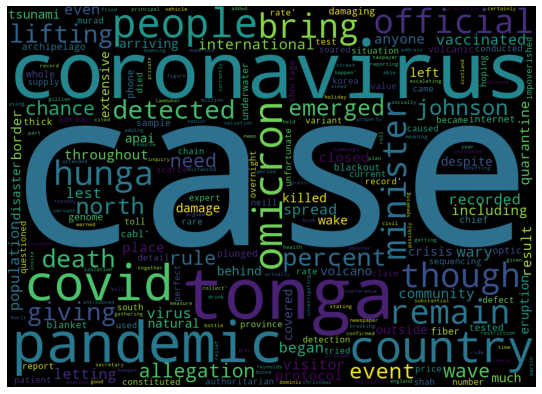

In [49]:
customStopwords = list(STOPWORDS)


wordcloudimage = WordCloud(
    max_words=5000,
    max_font_size=500,
    font_step=2,
    stopwords=customStopwords,
    background_color="black",
    width=1000,
    height=720,
).generate(str(df_new["clean_text"].values))

plt.figure(figsize=(15, 7))
plt.axis("off")
plt.imshow(wordcloudimage)
wordcloudimage
plt.show()

## Tokenization & Lemmatization

In [50]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()


def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]


df_new["clean_text"] = df_new["clean_text"].apply(lemmatize_text).str.join(" ")

## Visualize How the Words are Distributed in Different Categories

Here we extract the words from each category and rows, then we count the number of occurrences of each word using the Counter() function we imported earlier. We then plot out the frequency of the 10 most common words for each category. 

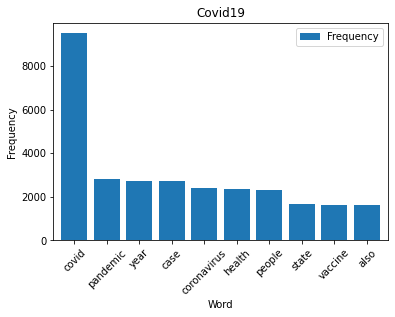

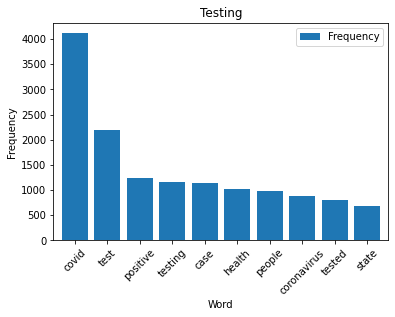

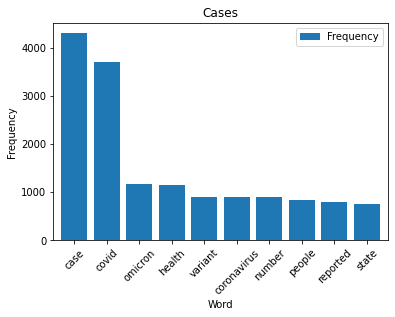

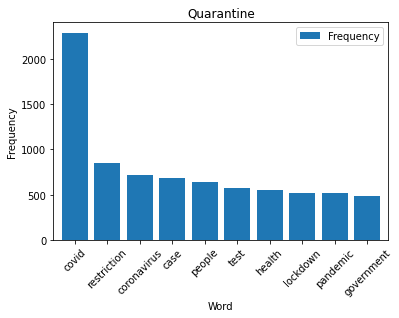

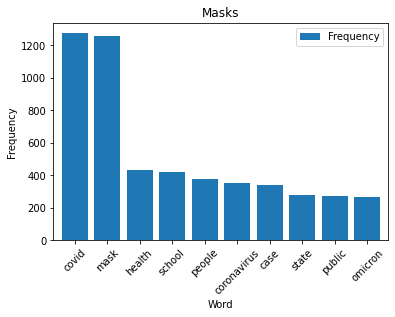

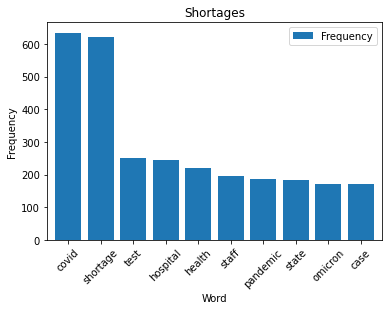

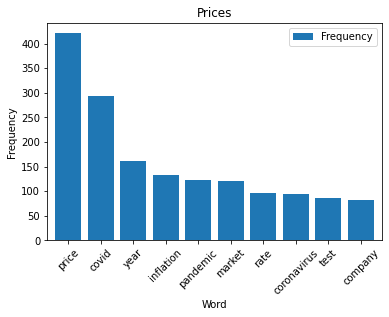

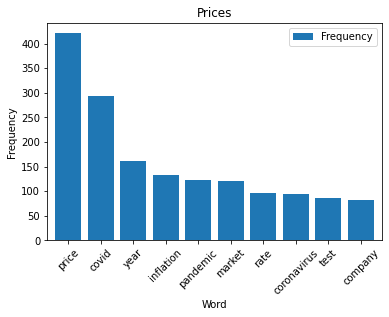

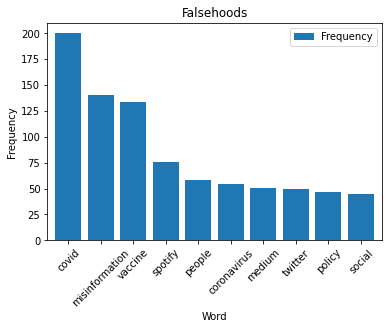

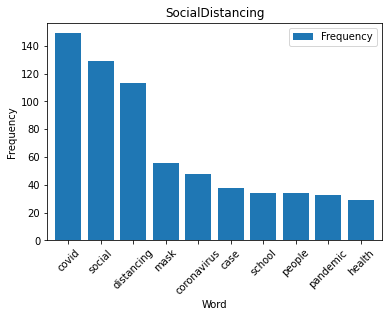

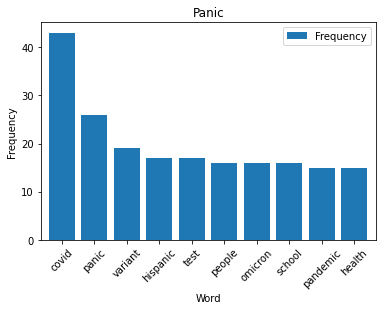

In [51]:
top_N = 10

for Topic in my_topics:
    words = df_new[df_new["Topic"] == Topic]["clean_text"].str.cat(sep=" ").split()

    # generate DF out of Counter
    rslt = pd.DataFrame(
        Counter(words).most_common(top_N), columns=["Word", "Frequency"]
    ).set_index("Word")
    # plot
    rslt.plot.bar(rot=45, width=0.8)
    plt.ylabel("Frequency")
    plt.title(Topic)
    plt.show()


We see some common words repeated across the categories like coronavirus and covid.

## Vectorization

We need to convert our text into vectors (meaningful representation of numbers) with a vectorizer, as our model can only deal with numbers, not alphabets. First, as with any machine learning task, we split our data into 2 groups of rows, the train and test sets using the train_test_split() function before vectorizing it.

Then we we use a TfidfVectorizer. Basically when this vectorizer is fitted on our data, it takes note of all terms/vocabulary (i.e. all the words and phrases involved) present in the text that we give it. An ngram_range of (1,2) was used so that we are no longer treating a single word, but double words frequently occurring together in the document.

The tfidf_vectorizer was fitted on only our training data to note all the terms involved, we then transform the training data into vectors which account for the frequency of this terms. This is done by the fit_transform() function below. We then use the same model to transform the test data into vectors. 

In [62]:
#for splitting later
X = df_new["clean_text"]
y = df_new["Topic"]

In [54]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(
    sublinear_tf=False,
    min_df=2,
    norm="l2",
    encoding="latin-1",
    ngram_range=(1, 2)
)

# Transform the training data: tfidf_train
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data: tfidf_test
tfidf_test = tfidf_vectorizer.transform(X_test)

In [55]:
tfidf_vectorizer

TfidfVectorizer(encoding='latin-1', min_df=2, ngram_range=(1, 2))

# Modelling

Five different Classification models were used to find the best model.

## SVC


In [70]:
svc_model = SVC(gamma='auto')
svc_model.fit(tfidf_train, y_train)
y_pred = svc_model.predict(tfidf_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.459


## Logistic Regression

In [64]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(tfidf_train, y_train)
y_pred = logreg.predict(tfidf_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.567


## DecisionTree Classifier

In [66]:
dtc = DecisionTreeClassifier()
dtc.fit(tfidf_train,y_train)
y_pred = dtc.predict(tfidf_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.5795


## XGBoost Classifier

In [67]:
model = XGBClassifier()
model.fit(tfidf_train,y_train)
y_pred = model.predict(tfidf_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.573


## KNeighborsClassifier

In [68]:
knn = KNeighborsClassifier()
knn.fit(tfidf_train, y_train)
y_pred = knn.predict(tfidf_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.467


In [71]:
def predict_topic(text):
    result = dtc.predict(tfidf_vectorizer.transform([text]))
    return(result[0])

In [73]:
predict_topic("symptoms are worse now")

'Covid19'

In [74]:
predict_topic("everyone stay indoors")

'Covid19'

## Save Results

In [72]:
with open('dtc.pkl', 'wb') as file:
   pickle.dump(dtc, file)
    
with open('tfidf_vectorizer.pkl', 'wb') as file:
   pickle.dump(tfidf_vectorizer, file)

# Observations and Future Improvements

This notebook demonstrats the basics of building a text classification model. 

For future improvements;

I observed from the data that all predictions are biased towards covid19 which is understandable because it is the largest topic in the dataset. The data is imbalanced, to improve this either an oversampling or undersampling technique can be used on the data to balance it and improve the results.

Also, using Gridsearch to fine tune the best selected model.